# <center>Data Generation and experimentation to understand regression</center>

### Initialize required packages

In [1]:
    %matplotlib inline

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
from random import randrange

### Step 1: Create predictor Variables

In [2]:
##############Define dataset#############
num_variables = 5
num_samples = 1000
##Correlation matrix
cov = [[1.0, 0.2, 0.1, 0.2, 0.3], 
       [0.2, 1.0, 0.1, 0.1, 0.2], 
       [0.1, 0.1, 1.0, 0.2, 0.2], 
       [0.2, 0.1, 0.2, 1.0, 0.3], 
       [0.3, 0.2, 0.2, 0.3, 1.0]]
mean = [50, 50, 50, 50, 50]
std_dev = [10, 10, 10, 10, 10]
##To ensure results remain consistent between runs for the same user definations
random_state = 23
##############Define dataset#############

rnd = np.random.RandomState(random_state)

## Creating cholesky decomposition matrix from correlation structure
L = np.linalg.cholesky(cov)

## Creating base dataset derived from standard normal distribution
uncorrelated = rnd.standard_normal((num_variables, num_samples))

## Imposing desired correlation structure on base dataset
correlated = np.dot(L, uncorrelated)
final_dataset = np.empty((num_variables, num_samples))

## Imposing mean and standard deviation on dataset
for i in range(0,num_variables):
    final_dataset[i] = correlated[i] * std_dev[i] + mean[i]

## Shape of numpy array as required by sklearn    
final_dataset = final_dataset.T

##############Check dataset#########################
print(np.corrcoef(final_dataset.T))
print(pd.DataFrame(final_dataset).describe())
##############Check dataset#########################

[[ 1.          0.14010411  0.07918163  0.13975212  0.26680898]
 [ 0.14010411  1.          0.06617256  0.07921974  0.18702709]
 [ 0.07918163  0.06617256  1.          0.25329078  0.25945618]
 [ 0.13975212  0.07921974  0.25329078  1.          0.27396032]
 [ 0.26680898  0.18702709  0.25945618  0.27396032  1.        ]]
                 0            1            2            3            4
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean     49.387729    49.784478    49.303834    49.345343    49.752428
std       9.622746    10.163527    10.171829     9.904923     9.701977
min      24.144755    16.247437    20.954768    15.609507    19.999783
25%      43.026066    43.151376    42.247023    41.899617    43.060687
50%      49.251580    49.683165    49.458126    49.633101    49.404889
75%      56.065987    56.624329    56.207225    56.126653    56.423824
max      81.875027    81.180788    82.332069    77.945018    76.298413


### Step 2: Create dependent variable from predictors according to desired parametric relation

396
[0.38410907205330996, 0.28272483973862617, 0.41658579663149237, 0.43974104080424953, 0.321079775371163]


(array([  17.,   69.,  124.,  178.,  152.,  171.,  157.,   94.,   31.,    7.]),
 array([  54579.47741265,   63967.72455989,   73355.97170714,
          82744.21885439,   92132.46600163,  101520.71314888,
         110908.96029612,  120297.20744337,  129685.45459062,
         139073.70173786,  148461.94888511]),
 <a list of 10 Patch objects>)

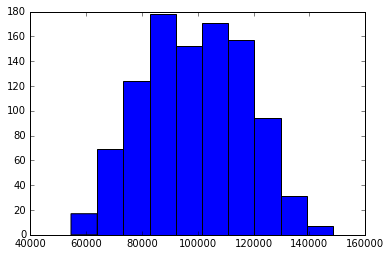

In [7]:
##function to created dependent variable valuea
def gen_data(inp, param, noise=0, n_outliers=0, random_state=0):
    rnd = np.random.RandomState(random_state)
    t=np.copy(inp.T)
    ##Reducing the effect of one the predictors
    dependence_reducer = rnd.randint(0, len(t[0]), 500)
    t[1][dependence_reducer] *= 0
    print(len(np.where(t[1] == 0)[0]))
    ##Parametric relation between dependant variable and predictors
    y = param[0] * (t[0]) + param[1] * (t[1]) + param[2] * (t[2]) + param[3] * (t[3]) + param[5]
    
    ##Generating gaussian error
    error = noise * rnd.randn(len(t[0]))
    ##Randomly assigning outlier positions
    outliers = rnd.randint(0, len(t[0]), n_outliers)
    error[outliers] *= 3
    #print(error)
    return y + error

##Model parameters
param = [555, 555, 555, 555, 555, 100]
noise = 10
n_outliers = 10

##Creating indendent predictor variables
t_train = np.array([[randrange(5,200) for x in range(0,num_samples)],[randrange(400,800) for x in range(0,num_samples)]]).T

##Using correlated predictor variables
t_train = final_dataset

y_train = gen_data(t_train, param, noise=noise, n_outliers=n_outliers, random_state=random_state)

#print(pd.DataFrame(y_train).describe())
y_correlation = [(np.corrcoef(y_train,idv)[0][1]) for idv in t_train.T]
print(y_correlation)
plt.hist(y_train.T)


### Experiment with statsmodels ols and rlm

In [6]:
from statsmodels.formula.api import ols,rlm

df = pd.DataFrame({'x0':t_train.T[0], 'x1':t_train.T[1], 'x2':t_train.T[2], 'x3':t_train.T[3], 'x4':t_train.T[4],'y':y_train})
ols_fit = rlm("y ~ x0+x1+x3+ x4 +1", df).fit()

print(ols_fit.summary())
print(np.mean((ols_fit.fittedvalues-df.y)**2)**.5)
#plt.scatter(y_train,ols_fit.fittedvalues-y_train)


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      995
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 22 Jul 2016                                         
Time:                        16:19:06                                         
No. Iterations:                     3                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.255e+04   3881.212      3.232      0.0

### Inferences from experimentation with regression:
1. robust least squares is better option. It may have higher RMSE but outlier treatment and better feature coefficient estimates and outlier treatment make it come out on top.

2. p values good for removing features but not good for being confident of the feature affecting the dependent variable.

3. High correlations (above .85) results in uncertainty of only the concerned features coefficients.

4. Importance of predictors can be found out by normalizing the feature set and judging from the coefficient values of the significant features. Uncertainty between highly correlated variables.

5. Correlations with dependent variable of features dont shed light on the actual relationship.

### Experimenting with scipy least_squares

{'shapiro_res': (0.9280182719230652, 1.715293699705991e-21), 'r_sq': 0.25692693664124766}
[  515.46041496   593.91637021   100.00000226   700.35329123   266.96359347
  1097.11692112]


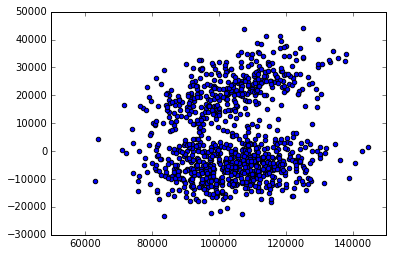

In [12]:
from scipy.optimize import least_squares
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.optimize._lsq.trf import trf
from scipy.optimize._lsq.dogbox import dogbox
from scipy.optimize._lsq.common import EPS, in_bounds, make_strictly_feasible


class ParametricModelling:
    
    def __init__(self, user_para_function=None, residual_function=False):
        self._residual_function = residual_function
        self.user_para_function = user_para_function
        self._x=None
        self._y=None
        self.coeff_ = None
        self.residuals_ = None
        
    def _para_residual_function(self, para, x, y):
        return np.array(self.user_para_function(para, x)) - y
            
    def fit(self, x0, jac='2-point', bounds=(-np.inf, np.inf), method='trf',
        ftol=EPS**0.5, xtol=EPS**0.5, gtol=EPS**0.5, x_scale=1.0,
        loss='linear', f_scale=1.0, diff_step=None, tr_solver=None,
        tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, x_data=None, y_data=None,
        kwargs={}):
        if self._residual_function == True:
            func = self.user_para_function
        else:
            func = self._para_residual_function
        res = least_squares(func, x0, jac=jac, bounds=bounds, method=method,
            ftol=ftol, xtol=xtol, gtol=gtol, x_scale=x_scale,
            loss=loss, f_scale=f_scale, diff_step=diff_step, tr_solver=tr_solver,
            tr_options=tr_options, jac_sparsity=jac_sparsity, max_nfev=max_nfev, verbose=verbose, args=(x_data.T,y_data),
            kwargs=kwargs)
        self._x=x_data
        self._y=y_data
        self.residuals_ = res.fun
        self.coeff_ = res.x
        return self
    
    def predict(self, inp):
        if self._residual_function == True:
            return self.user_para_function(self.coeff, np.array(inp).T, y=0)
        else:
            return self.user_para_function(self.coeff, np.array(inp).T)
    
    def model_metrics(self):
        r_sq = 1 - (np.mean(self.residuals_**2) /
        np.mean((self._y-np.mean(self._y))**2)) 
        
        shapiro_res = shapiro(self.residuals_)
        
        return {'r_sq': r_sq, 'shapiro_res': shapiro_res}
    

def func(coeff,X):
    return coeff[0] * (X[0]) + coeff[1] * (X[1]) + coeff[3] * (X[3]) + coeff[4] * (X[4]) + coeff[5]    

test = ParametricModelling(func)


    
test = test.fit([100,100,100,100,100,100], x_data=t_train,y_data= y_train,loss='huber' )
print(test.model_metrics())

print(test.coeff_)

plt.scatter(y_train+test.residuals_,test.residuals_)
    
    
    
        